In [57]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys

import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pprint

# !rm "../../results/arousal--model_fusion_0.3432.dat"
path = "../../results/"
!ls "../../results/"

20180125-121411--arousal--model_early_0.6803.dat
20180125-140019--arousal--model_fusion_0.6889.dat
20180125-151303--arousal--model_early_0.7892.dat
20180125-155549--arousal--model_fusion_0.7747.dat
20180125-164754--arousal--model_early_0.7892.dat
20180125-165106--arousal--model_fusion_0.7895.dat


In [58]:
name = "20180125-164754--arousal--model_early_0.7892.dat"

data = None
with open(path + name,'r') as f:  
    data = pickle.load(f)

In [56]:
def hyper_average():
    av = []
    for hy in data:
        av.append(hy['loss'])
    
    print("Average over hyper parameters losses : {} with std of : {}".format(sum(av)/len(data), np.std(av)))

if len(data) > 1:
    hyper_average()

Average over hyper parameters losses : 0.679739296436 with std of : 0.0526371895373


In [28]:
max_ccc = max(data, key=lambda item: item["loss"])

In [29]:
print(max_ccc["graph"])
print(max_ccc["space"])
print("\nAVG CCC and STD : {:.4f} and {:.4f}".format(max_ccc["loss"], max_ccc["ccc_std"]))
print("AVG LOSS and STD : {:.4f} and {:.4f}".format(max_ccc["validation"], max_ccc["loss_std"]))


UniModalNet(
  (net): Sequential(
    (input): Linear(in_features=888, out_features=300)
    (act_0): Sigmoid()
    (drop_out_0): Dropout(p=0.2)
    (fc_1): Linear(in_features=300, out_features=100)
    (act_1): Sigmoid()
    (drop_out_1): Dropout(p=0.4)
    (regression): Linear(in_features=100, out_features=1)
  )
)
{'delay': 2.8, 'name': 'early', 'win': 1, 'test_batch_size': 1000, 'batch_size': 256, 'epochs': 50, 'patience': -1, 'seed': 10, 'lr': 0.01, 'mode': 0, 'fusion_layers': [([200, 100], 0.2), ([50, 50], 0.4)], 'cv': True, 'opt_algo': 'sgd'}

AVG CCC and STD : 0.6803 and 0.1283
AVG LOSS and STD : 0.0147 and 0.0051


In [33]:
def calculate_csv_alpha(cv):
    import pandas as pd
    i = []
    o = []
    alpha_0 = []
    alpha_1 = []
    w_0 = []
    w_1 = []
    w_2 = []
    

    l = len(cv)
    for cvf in cv:
        bmi = cvf['best_model_inter']
        i.append(np.asarray(bmi['inputs']))
        o.append(np.asarray(bmi['outputs']))
        for idx, f in enumerate(bmi['fusion_layers']):
            if idx == 0:
                alpha_0.append(np.asarray(f['alpha']))
                w_0.append(np.asarray(f['weights']))
            elif idx == 1:
                alpha_1.append(np.asarray(f['alpha']))
                w_1.append(np.asarray(f['weights']))
            elif idx == 2:
                w_2.append(np.asarray(f['weights']))
    
    average_input = sum(i)/float(l)
    average_output = sum(o)/float(l)

    input_std = np.std(i)
    output_std = np.std(o)
    
    average_alpha_0 = sum(alpha_0)/float(l)
    average_alpha_1 = sum(alpha_1)/float(l)
    
    alpha_0_std = np.std(alpha_0)
    alpha_1_std = np.std(alpha_1)
    
    average_w_0 = sum(w_0)/float(l)
    average_w_1 = sum(w_1)/float(l)
    average_w_2 = sum(w_2)/float(l)
    
    w_0_std = np.std(w_0)
    w_1_std = np.std(w_0)
    w_2_std = np.std(w_0)
    
    print("input average : {} and std : {}".format(average_input, input_std))
    print("output average : {} and std : {}".format(average_output, output_std))
    print("a_0 average : {} and std : {}".format(average_alpha_0, alpha_0_std))
    print("w_0 average : {} and std : {}".format(average_w_0, w_0_std))
    print("a_1 average : {} and std : {}".format(average_alpha_1, alpha_1_std))
    print("w_1 average : {} and std : {}".format(average_w_1, w_1_std))
    print("w_2 average : {} and std : {}".format(average_w_2, w_2_std))
    
if max_ccc['space']['name'] == 'fusion':
    calculate_csv_alpha(max_ccc['cross_valid'])

In [34]:
max_cross = max(max_ccc['cross_valid'], key=lambda item: item["loss"])
# max_cross = max_ccc['cross_valid'][1]

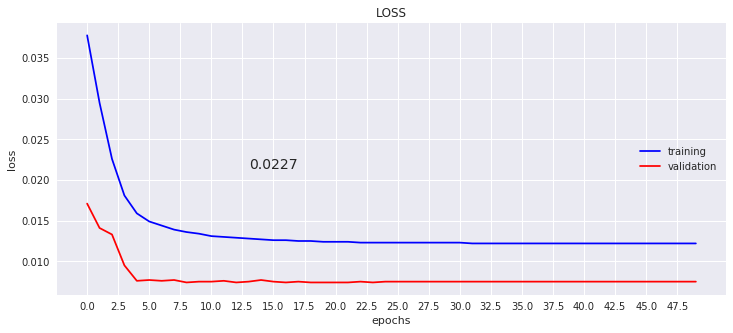

In [35]:
stats = max_cross["stats"]
epochs = len(stats["train"]["loss"])
plt.subplots(1, figsize=(12, 5), sharey=True)
plt.plot(stats["train"]["loss"],'b', label='training')
plt.plot(stats["valid"]["loss"], 'r', label='validation')

plt.xticks(np.arange(0, epochs, epochs/20))
plt.xlabel('epochs')
plt.ylabel("loss")
plt.legend(loc=5)
plt.title("LOSS")
point = (max_cross["best_epoch_loss"], max_cross["best_valid_loss"])
plt.annotate(str(point[1]), xy=point, xytext=point, fontsize=14, verticalalignment='top')
plt.show()

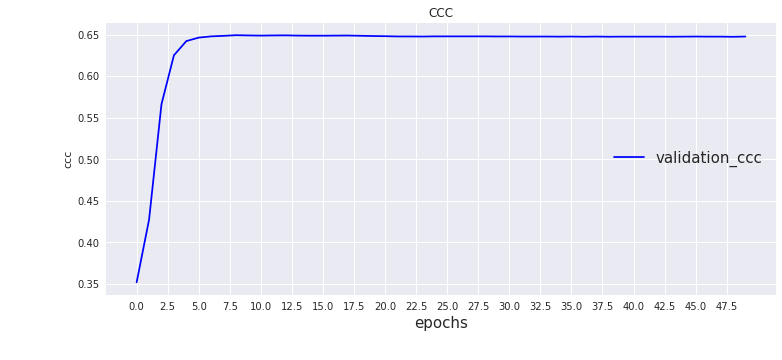

In [36]:
plt.subplots(1, figsize=(12, 5), sharey=True)
plt.plot(stats["valid"]["ccc"], 'b', label='validation_ccc')

plt.xticks(np.arange(0, epochs, epochs/20))
plt.xlabel('epochs', fontsize=15)
plt.ylabel("ccc")
plt.legend(fontsize=15, loc=5)
plt.title("CCC")
point = (max_cross["best_epoch_ccc"], max_cross["loss"])
plt.annotate(str(point[1]), xy=point, xytext=point, fontsize=14, verticalalignment='top')
plt.show()

In [33]:
def calc_scores ( x, y ):
    x_mean = np.nanmean(x)
    y_mean = np.nanmean(y)
    
    covariance = np.nanmean((x-x_mean)*(y-y_mean))
    
    x_var = 1.0 / (len(x)-1) * np.nansum((x-x_mean)**2) # Make it consistent with Matlab's nanvar (division by len(x)-1, not len(x)))
    y_var = 1.0 / (len(y)-1) * np.nansum((y-y_mean)**2)
    
    CCC = (2*covariance) / (x_var + y_var + (x_mean-y_mean)**2)

    return CCC


Speaker  0
CCC:  0.30402836219


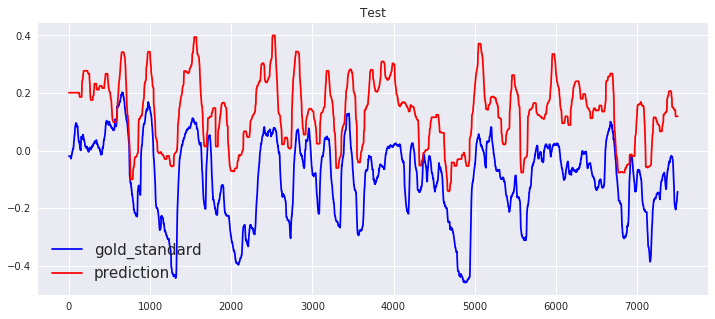

Speaker  1
CCC:  0.198202488688


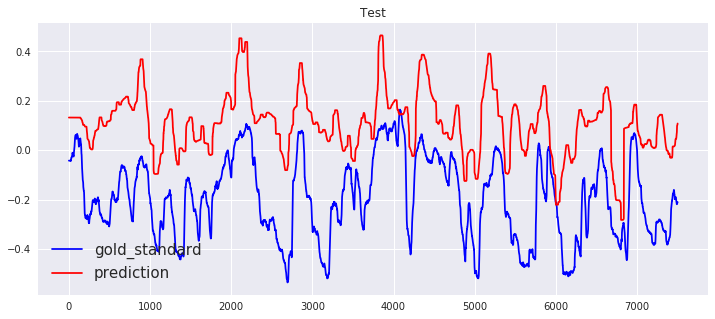

Speaker  2
CCC:  0.173249620307


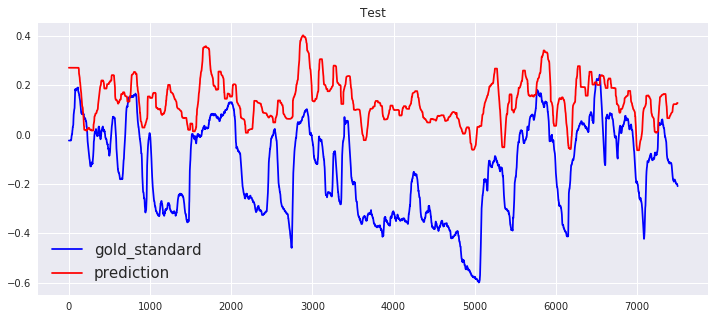

Speaker  3
CCC:  0.356780923674


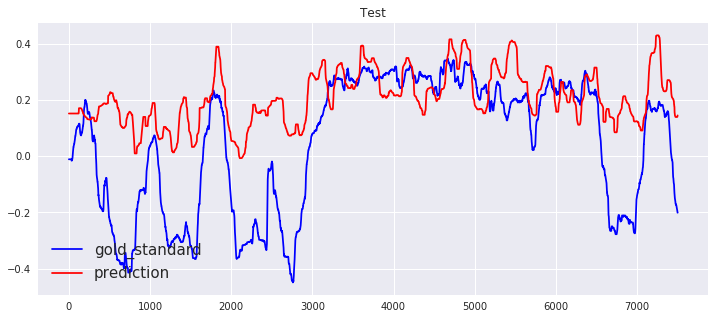

Speaker  4
CCC:  0.380972540734


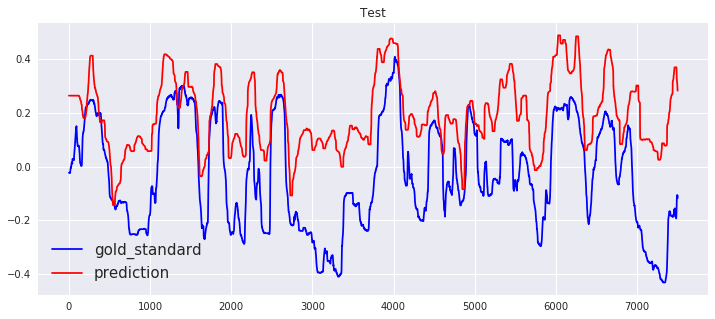

Speaker  5
CCC:  0.41619400099


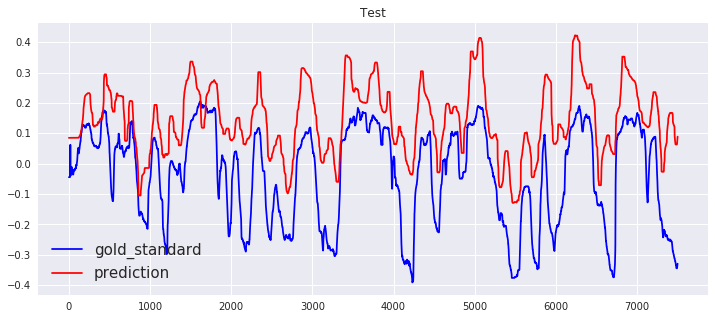

Speaker  6
CCC:  0.304254378626


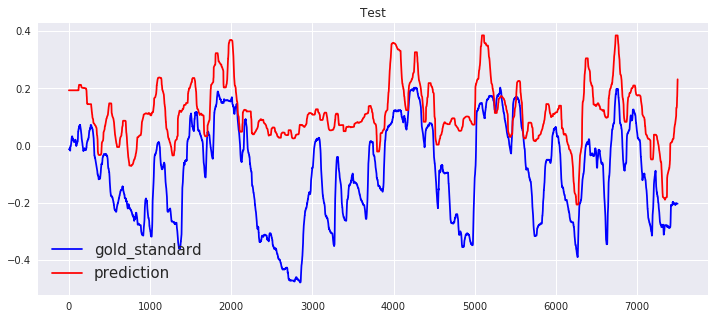

Speaker  7
CCC:  0.263983368656


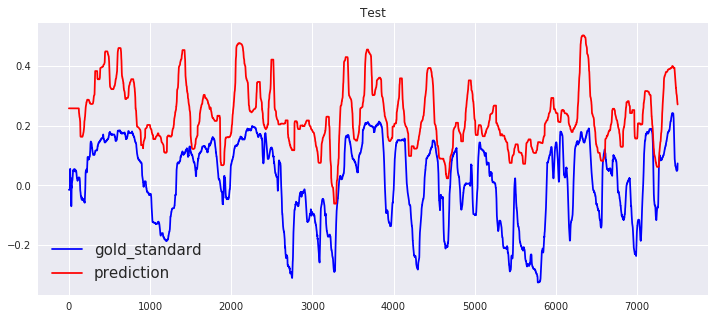

Speaker  8
CCC:  0.374156697776


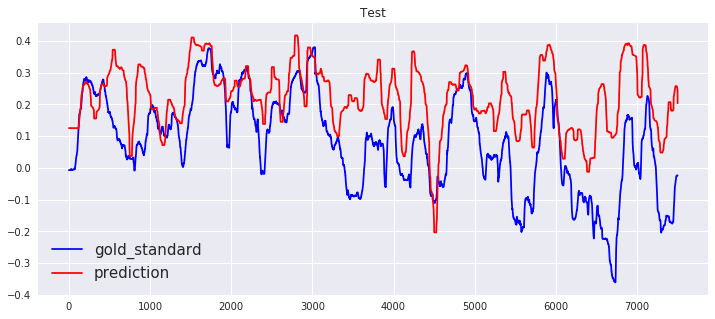

In [39]:
def plot_test_speaker(speaker):

    targe_stats = stats["test"]
    print("Speaker " , speaker)
    print("CCC: ", calc_scores(targe_stats["results"]["label"][speaker*7501:(speaker+1)*7501], 
                                               targe_stats["results"]["pred"][speaker*7501:(speaker+1)*7501]))

    plt.subplots(1, figsize=(12, 5), sharey=True)
    plt.plot(targe_stats["results"]["label"][speaker*7501:(speaker+1)*7501], 'b', label='gold_standard')
    plt.plot(targe_stats["results"]["pred"][speaker*7501:(speaker+1)*7501], 'r', label='prediction')

    plt.legend(fontsize=15, loc=3)
    plt.title("Test")
    plt.show()

for i in range(0,9):
    plot_test_speaker(i)

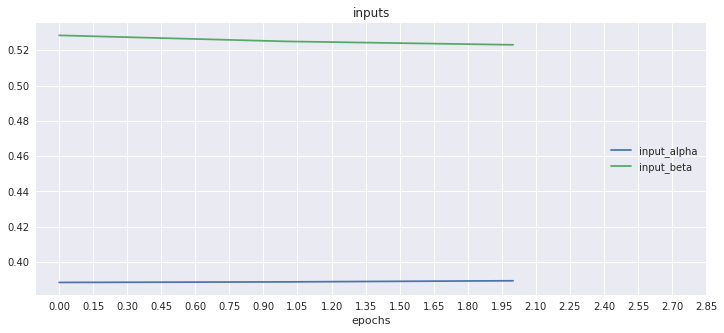

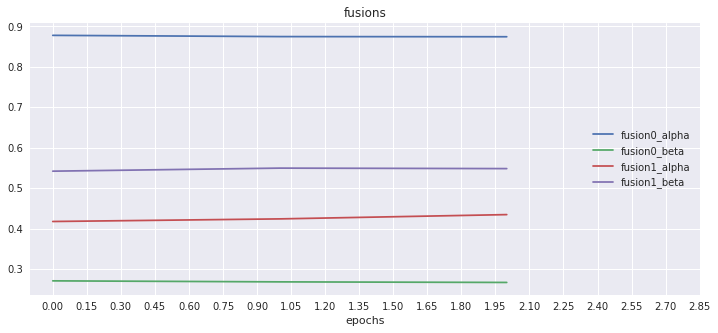

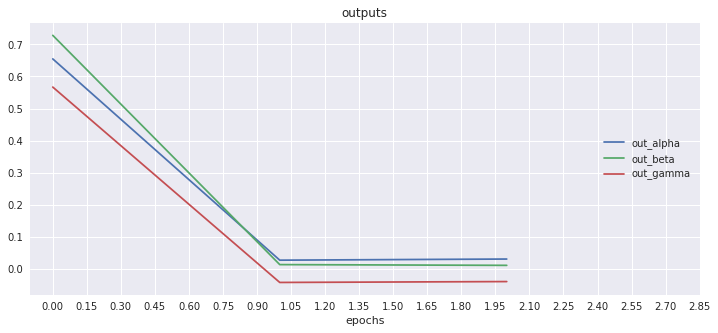

In [35]:
alpha_hist = max_cross["alphas"]
m = [[[] for x in range(3)] for y in range(4)]
for i in alpha_hist:
    m[0][0].append(i['inputs'][0])
    m[0][1].append(i['inputs'][1])
    f_l = i['fusion_layers'][0]
    m[1][0].append(f_l['alpha'][0])
    m[1][1].append(f_l['alpha'][1])
    f_l = i['fusion_layers'][1]
    m[2][0].append(f_l['alpha'][0])
    m[2][1].append(f_l['alpha'][1])
    m[3][0].append(i['outputs'][0])
    m[3][1].append(i['outputs'][1])
    m[3][2].append(i['outputs'][2])

def end(plt):
    plt.xticks(np.arange(0, epochs, epochs/20))
    plt.xlabel('epochs')
    plt.legend(loc=5)
    plt.show()
    
    
plt.subplots(1, figsize=(12, 5), sharey=True)
# plt.subplot(3, 1, 1)
plt.plot(m[0][0], label='input_alpha')
plt.plot(m[0][1], label='input_beta')
plt.title("inputs")
end(plt)


# plt.subplot(3, 1, 2)
plt.subplots(1, figsize=(12, 5), sharey=True)
plt.plot(m[1][0], label='fusion0_alpha')
plt.plot(m[1][1], label='fusion0_beta')
plt.plot(m[2][0], label='fusion1_alpha')
plt.plot(m[2][1], label='fusion1_beta')
plt.title("fusions")
end(plt)

# plt.subplot(3, 1, 3)
plt.subplots(1, figsize=(12, 5), sharey=True)
plt.plot(m[3][0], label='out_alpha')
plt.plot(m[3][1], label='out_beta')
plt.plot(m[3][2], label='out_gamma')
plt.title("outputs")
end(plt)

In [36]:
alpha = max_cross["best_model_inter"]
print(alpha)

{'inputs': [0.3911553, 0.52521425], 'fusion_layers': [{'alpha': [0.87620193, 0.26732633], 'weights': [0.58187342, 0.57137895, 0.58748215]}, {'alpha': [0.44746068, 0.54896152], 'weights': [0.57191211, 0.58045226, 0.58887875]}, {'alpha': [], 'weights': [0.49407554, 0.52143604, 0.54485273]}], 'outputs': [0.048428971, 0.017152559, -0.035274476], 'final_weight': array([ 0.33951908, -0.28366286, -0.49975762], dtype=float32)}


In [37]:
import sys
sys.path.append('/home/AP27660/fusion/src')

In [38]:
%%HTML
<iframe src="graph/index.html" width=1024 height=500></iframe>